# **Histopathologic Cancer Detection**

In [ ]:
import numpy as np
import pandas as pd

import os
base_dir = '../input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Matplotlib and Seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from PIL import Image
from tqdm import tqdm

**Read data**

In [2]:
full_data = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
full_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


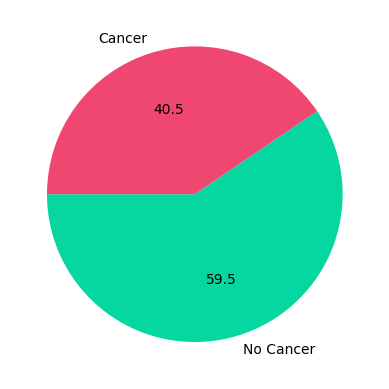

<Figure size 1600x1600 with 0 Axes>

label
0    130908
1     89117
Name: count, dtype: int64

In [3]:
labels_count = full_data.label.value_counts()

plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#06d6a0','#ef476f'])
plt.figure(figsize=(16,16))
plt.show()

labels_count

**Sampling data**

In [4]:
# Number of samples in each class
SAMPLE_SIZE = 89000

# Data paths
train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'

# Use 89000 positive and negative examples
df_negatives = full_data[full_data['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_data[full_data['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
data = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

data.shape

(178000, 2)

**Data Preprocessing**

In [5]:
# Split data into train and test
test_ratio = 0.1  

train_df, test_df = train_test_split(
    data, 
    test_size=test_ratio, 
    stratify=data['label'],   # Ensure fair distribution of label
    random_state=42
)

In [6]:
# Save to CSV
train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

In [7]:
# Customize class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        super().__init__()
        self.df = df_data.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df.iloc[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [8]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [10]:
batch_size = 128    # Set Batch Size
valid_size = 0.2    # Percentage of training set to use as validation

num_train = len(train_data)  
train_size = int((1 - valid_size) * num_train)  
valid_size = num_train - train_size  

train_data, valid_data = random_split(train_data, [train_size, valid_size])

# Prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [11]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Creating test data
test_data = CreateDataset(df_data=test_df, data_dir=train_path, transform=transforms_test)

# Prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Defining Model Architecture**

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [13]:
# Create a complete CNN
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [15]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


**Training Model**

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    """ 
    Train & validate a PyTorch model 
        Args: 
            model : CNN model 
            train_loader: DataLoader cho tập train 
            val_loader : DataLoader cho tập validation 
            criterion : Loss function (nn.BCELoss hoặc nn.CrossEntropyLoss) 
            optimizer : Optimizer (Adam, SGD,...) 
            device : 'cuda' hoặc 'cpu' 
            num_epochs : số epoch huấn luyện 
        Returns: 
            model : mô hình sau khi train 
            history : dict chứa loss/acc theo epoch 
    """
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_auc": [],
        "val_auc": []
    }
    
    best_val_loss = float("inf")
    best_model_wts = model.state_dict()
    
    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # ------------------------
        # TRAINING PHASE
        # ------------------------
        model.train()
        running_loss, total = 0.0, 0
        all_labels, all_outputs = [], []

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images).squeeze()   # đã sigmoid rồi
            loss = criterion(outputs, labels.float())

            all_outputs.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            total += labels.size(0)
        
        epoch_train_loss = running_loss / total
        try:
            epoch_train_auc = roc_auc_score(all_labels, all_outputs)
        except ValueError:
            epoch_train_auc = 0.0

        # ------------------------
        # VALIDATION PHASE
        # ------------------------
        model.eval()
        val_loss, val_total = 0.0, 0
        val_labels, val_outputs = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images).squeeze() 
                loss = criterion(outputs, labels.float())

                val_outputs.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())
                
                val_loss += loss.item() * images.size(0)
                val_total += labels.size(0)
        
        epoch_val_loss = val_loss / val_total
        try:
            epoch_val_auc = roc_auc_score(val_labels, val_outputs)
        except ValueError:
            epoch_val_auc = 0.0

        # ------------------------
        # LOGGING
        # ------------------------
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_auc"].append(epoch_train_auc)
        history["val_auc"].append(epoch_val_auc)

        print(f"Train Loss: {epoch_train_loss:.4f} AUC: {epoch_train_auc:.4f}")
        print(f"Valid Loss: {epoch_val_loss:.4f} AUC: {epoch_val_auc:.4f}")
        
        # ------------------------
        # SAVE BEST MODEL (theo val_loss nhỏ nhất)
        # ------------------------
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, "best_model.pth")
            print(">>> Saved best model with Val Loss:", best_val_loss)
    
    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history

In [17]:
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00015)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00015, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=0.00015, weight_decay=1e-4)

In [18]:
model, history = train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=30)


Epoch 1/30
------------------------------


Validation: 100%|██████████| 251/251 [05:40<00:00,  1.36s/it]


Train Loss: 0.3758 AUC: 0.9131
Valid Loss: 0.3941 AUC: 0.9160
>>> Saved best model with Val Loss: 0.3941014623299669

Epoch 2/30
------------------------------


Validation: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s]


Train Loss: 0.3012 AUC: 0.9448
Valid Loss: 0.2719 AUC: 0.9586
>>> Saved best model with Val Loss: 0.2718802912776985

Epoch 3/30
------------------------------


Validation: 100%|██████████| 251/251 [01:09<00:00,  3.62it/s]


Train Loss: 0.2684 AUC: 0.9561
Valid Loss: 0.2652 AUC: 0.9668
>>> Saved best model with Val Loss: 0.2652029350716225

Epoch 4/30
------------------------------


Validation: 100%|██████████| 251/251 [01:24<00:00,  2.98it/s]


Train Loss: 0.2444 AUC: 0.9635
Valid Loss: 0.2291 AUC: 0.9708
>>> Saved best model with Val Loss: 0.22913244058948926

Epoch 5/30
------------------------------


Validation: 100%|██████████| 251/251 [01:19<00:00,  3.14it/s]


Train Loss: 0.2287 AUC: 0.9677
Valid Loss: 0.2448 AUC: 0.9718

Epoch 6/30
------------------------------


Validation: 100%|██████████| 251/251 [01:03<00:00,  3.98it/s]


Train Loss: 0.2145 AUC: 0.9716
Valid Loss: 0.2075 AUC: 0.9747
>>> Saved best model with Val Loss: 0.2075418480587065

Epoch 7/30
------------------------------


Validation: 100%|██████████| 251/251 [01:22<00:00,  3.05it/s]


Train Loss: 0.2049 AUC: 0.9740
Valid Loss: 0.2783 AUC: 0.9681

Epoch 8/30
------------------------------


Validation: 100%|██████████| 251/251 [01:16<00:00,  3.27it/s]


Train Loss: 0.1968 AUC: 0.9759
Valid Loss: 0.2507 AUC: 0.9767

Epoch 9/30
------------------------------


Validation: 100%|██████████| 251/251 [01:15<00:00,  3.30it/s]


Train Loss: 0.1888 AUC: 0.9778
Valid Loss: 0.1905 AUC: 0.9780
>>> Saved best model with Val Loss: 0.19054857634947392

Epoch 10/30
------------------------------


Validation: 100%|██████████| 251/251 [01:27<00:00,  2.86it/s]


Train Loss: 0.1824 AUC: 0.9792
Valid Loss: 0.1682 AUC: 0.9832
>>> Saved best model with Val Loss: 0.16824252836675976

Epoch 11/30
------------------------------


Validation: 100%|██████████| 251/251 [00:59<00:00,  4.19it/s]


Train Loss: 0.1785 AUC: 0.9801
Valid Loss: 0.1689 AUC: 0.9826

Epoch 12/30
------------------------------


Validation: 100%|██████████| 251/251 [01:19<00:00,  3.18it/s]


Train Loss: 0.1721 AUC: 0.9815
Valid Loss: 0.1681 AUC: 0.9848
>>> Saved best model with Val Loss: 0.16813048004508763

Epoch 13/30
------------------------------


Validation: 100%|██████████| 251/251 [01:00<00:00,  4.15it/s]


Train Loss: 0.1688 AUC: 0.9821
Valid Loss: 0.1921 AUC: 0.9825

Epoch 14/30
------------------------------


Validation: 100%|██████████| 251/251 [01:03<00:00,  3.95it/s]


Train Loss: 0.1638 AUC: 0.9831
Valid Loss: 0.1628 AUC: 0.9867
>>> Saved best model with Val Loss: 0.16276617031195637

Epoch 15/30
------------------------------


Validation: 100%|██████████| 251/251 [00:56<00:00,  4.44it/s]


Train Loss: 0.1608 AUC: 0.9838
Valid Loss: 0.1531 AUC: 0.9855
>>> Saved best model with Val Loss: 0.15311259068874236

Epoch 16/30
------------------------------


Validation: 100%|██████████| 251/251 [01:01<00:00,  4.07it/s]


Train Loss: 0.1542 AUC: 0.9850
Valid Loss: 0.1538 AUC: 0.9854

Epoch 17/30
------------------------------


Validation: 100%|██████████| 251/251 [01:18<00:00,  3.19it/s]


Train Loss: 0.1526 AUC: 0.9853
Valid Loss: 0.1576 AUC: 0.9859

Epoch 18/30
------------------------------


Validation: 100%|██████████| 251/251 [01:26<00:00,  2.89it/s]


Train Loss: 0.1470 AUC: 0.9863
Valid Loss: 0.1445 AUC: 0.9874
>>> Saved best model with Val Loss: 0.1444908999771661

Epoch 19/30
------------------------------


Validation: 100%|██████████| 251/251 [01:16<00:00,  3.26it/s]


Train Loss: 0.1455 AUC: 0.9866
Valid Loss: 0.1409 AUC: 0.9880
>>> Saved best model with Val Loss: 0.14088855407732107

Epoch 20/30
------------------------------


Validation: 100%|██████████| 251/251 [01:44<00:00,  2.40it/s]


Train Loss: 0.1429 AUC: 0.9870
Valid Loss: 0.1556 AUC: 0.9872

Epoch 21/30
------------------------------


Validation: 100%|██████████| 251/251 [00:56<00:00,  4.43it/s]


Train Loss: 0.1386 AUC: 0.9878
Valid Loss: 0.1604 AUC: 0.9882

Epoch 22/30
------------------------------


Validation: 100%|██████████| 251/251 [00:55<00:00,  4.51it/s]


Train Loss: 0.1368 AUC: 0.9882
Valid Loss: 0.1488 AUC: 0.9868

Epoch 23/30
------------------------------


Validation: 100%|██████████| 251/251 [00:55<00:00,  4.54it/s]


Train Loss: 0.1337 AUC: 0.9887
Valid Loss: 0.1784 AUC: 0.9857

Epoch 24/30
------------------------------


Validation: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Train Loss: 0.1316 AUC: 0.9889
Valid Loss: 0.1356 AUC: 0.9898
>>> Saved best model with Val Loss: 0.13560198015078773

Epoch 25/30
------------------------------


Validation: 100%|██████████| 251/251 [01:23<00:00,  2.99it/s]


Train Loss: 0.1283 AUC: 0.9894
Valid Loss: 0.1269 AUC: 0.9902
>>> Saved best model with Val Loss: 0.12694528874070307

Epoch 26/30
------------------------------


Validation: 100%|██████████| 251/251 [00:58<00:00,  4.32it/s]


Train Loss: 0.1266 AUC: 0.9898
Valid Loss: 0.1339 AUC: 0.9888

Epoch 27/30
------------------------------


Validation: 100%|██████████| 251/251 [01:14<00:00,  3.37it/s]


Train Loss: 0.1252 AUC: 0.9900
Valid Loss: 0.1216 AUC: 0.9909
>>> Saved best model with Val Loss: 0.1216055369276679

Epoch 28/30
------------------------------


Validation: 100%|██████████| 251/251 [01:07<00:00,  3.69it/s]


Train Loss: 0.1224 AUC: 0.9904
Valid Loss: 0.1221 AUC: 0.9904

Epoch 29/30
------------------------------


Validation: 100%|██████████| 251/251 [00:57<00:00,  4.39it/s]


Train Loss: 0.1188 AUC: 0.9909
Valid Loss: 0.1306 AUC: 0.9903

Epoch 30/30
------------------------------


Validation: 100%|██████████| 251/251 [00:56<00:00,  4.45it/s]

Train Loss: 0.1187 AUC: 0.9909
Valid Loss: 0.1808 AUC: 0.9894


In [19]:
import pickle

with open("train_history.pkl", "wb") as f:
    pickle.dump(history, f)

In [20]:
def plot_history(history):
    # Plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

In [20]:
def evaluate_model(model, data_loader, device, threshold=None, min_tpr=0.95, tune_threshold=True):
    """
    Evaluate model trên tập dữ liệu và (tuỳ chọn) tự động tìm threshold tốt nhất
    theo tiêu chí Recall (TPR) ưu tiên.
    
    Args:
        model : mô hình đã huấn luyện
        data_loader : DataLoader cho tập validation/test
        device : 'cuda' hoặc 'cpu'
        threshold : threshold cố định (nếu không muốn auto-tune)
        min_tpr : ngưỡng tối thiểu của Recall khi tune threshold
        tune_threshold : nếu True -> tự động tìm threshold tối ưu theo Recall

    Returns:
        metrics : dict chứa kết quả đánh giá
    """
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            
            # Nếu model cuối có Sigmoid rồi thì bỏ sigmoid ở đây
            if logits.shape[-1] == 1:
                probs = logits.squeeze().detach().cpu().numpy()
            else:
                probs = torch.sigmoid(logits).squeeze().detach().cpu().numpy()

            y_probs.extend(probs)
            y_true.extend(yb.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)

    # =====================
    # 1️⃣ Tune threshold nếu bật
    # =====================
    if tune_threshold:
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        valid_idx = np.where(tpr >= min_tpr)[0]

        if len(valid_idx) == 0:
            print(f"⚠️ Không có threshold nào đạt TPR >= {min_tpr}. Sẽ chọn threshold với TPR cao nhất.")
            best_idx = np.argmax(tpr)
        else:
            best_idx = valid_idx[np.argmin(fpr[valid_idx])]

        threshold = thresholds[best_idx]
        print(f"\n🔍 Tuning threshold (TPR priority): {threshold:.4f}")
        print(f"TPR={tpr[best_idx]:.4f}, FPR={fpr[best_idx]:.4f}")

    elif threshold is None:
        threshold = 0.5  # Mặc định

    # =====================
    # 2️⃣ Áp dụng threshold để tính metric
    # =====================
    y_pred = (y_probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        auc = None

    report = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)

    print("\n=== Evaluation Report ===")
    print(f"Accuracy : {acc:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print(f"Threshold: {threshold:.4f}")
    print("\nClassification Report:\n", report)

    # =====================
    # 3️⃣ Confusion Matrix
    # =====================
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold={threshold:.3f})")
    plt.show()

    # =====================
    # 4️⃣ ROC Curve
    # =====================
    if auc is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    return {
        "accuracy": acc,
        "auc": auc,
        "report": report,
        "confusion_matrix": cm,
        "threshold": threshold
    }

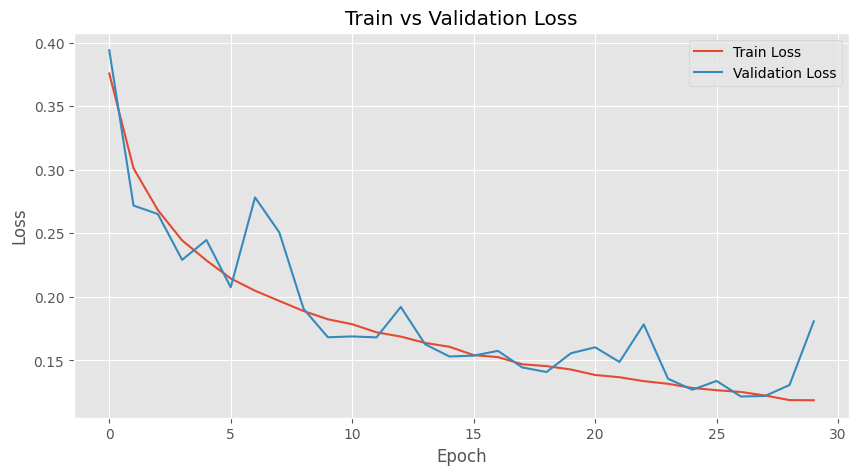

In [22]:
%matplotlib inline
plot_history(history)


🔍 Tuning threshold (TPR priority): 0.6303
TPR=0.9500, FPR=0.0331

=== Evaluation Report ===
Accuracy : 0.9584
ROC AUC  : 0.9917
Threshold: 0.6303

Classification Report:
               precision    recall  f1-score   support

           0     0.9508    0.9669    0.9588      8900
           1     0.9663    0.9500    0.9581      8900

    accuracy                         0.9584     17800
   macro avg     0.9586    0.9584    0.9584     17800
weighted avg     0.9586    0.9584    0.9584     17800



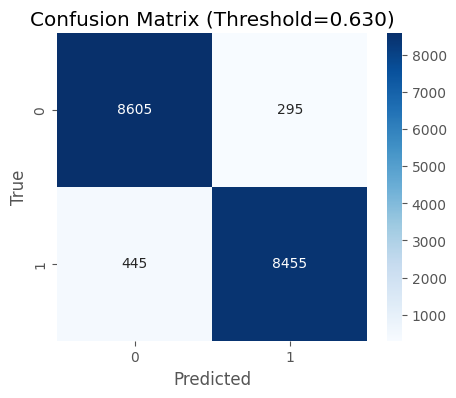

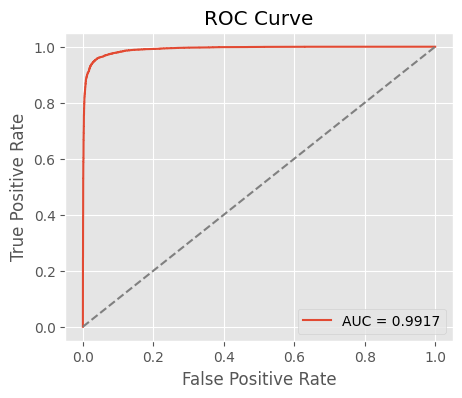

In [21]:
test_results = evaluate_model(
    model,
    test_loader,
    device,
    tune_threshold=True,
    min_tpr=0.95
)